In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import copy

import matplotlib.pyplot as plt
import neuromodels as nm
import numpy as np
import pandas as pd
import pylfi
import quantities as pq
import scipy.stats as stats
import seaborn as sns

from matplotlib import gridspec

# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

# Set fontsizes in figures
size = 10
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": size,
    "font.size": size,
    "legend.fontsize": size,
    "xtick.labelsize": size-1,
    "ytick.labelsize": size-1,
    'legend.handlelength': 2
}

params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'legend.fontsize': 'large',
          'legend.handlelength': 2
         }

plt.rcParams.update(params)
plt.rc('text', usetex=True)

[INFO] [2021.12.8 0:45:19 /Users/runner/miniforge3/conda-bld/nest-simulator_1633677025151/work/nestkernel/rng_manager.cpp:217 @ Network::create_rngs_] : Creating default RNGs
[INFO] [2021.12.8 0:45:19 /Users/runner/miniforge3/conda-bld/nest-simulator_1633677025151/work/nestkernel/rng_manager.cpp:260 @ Network::create_grng_] : Creating new default global RNG

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-2.20.2
 Built: Oct  8 2021 07:17:41

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



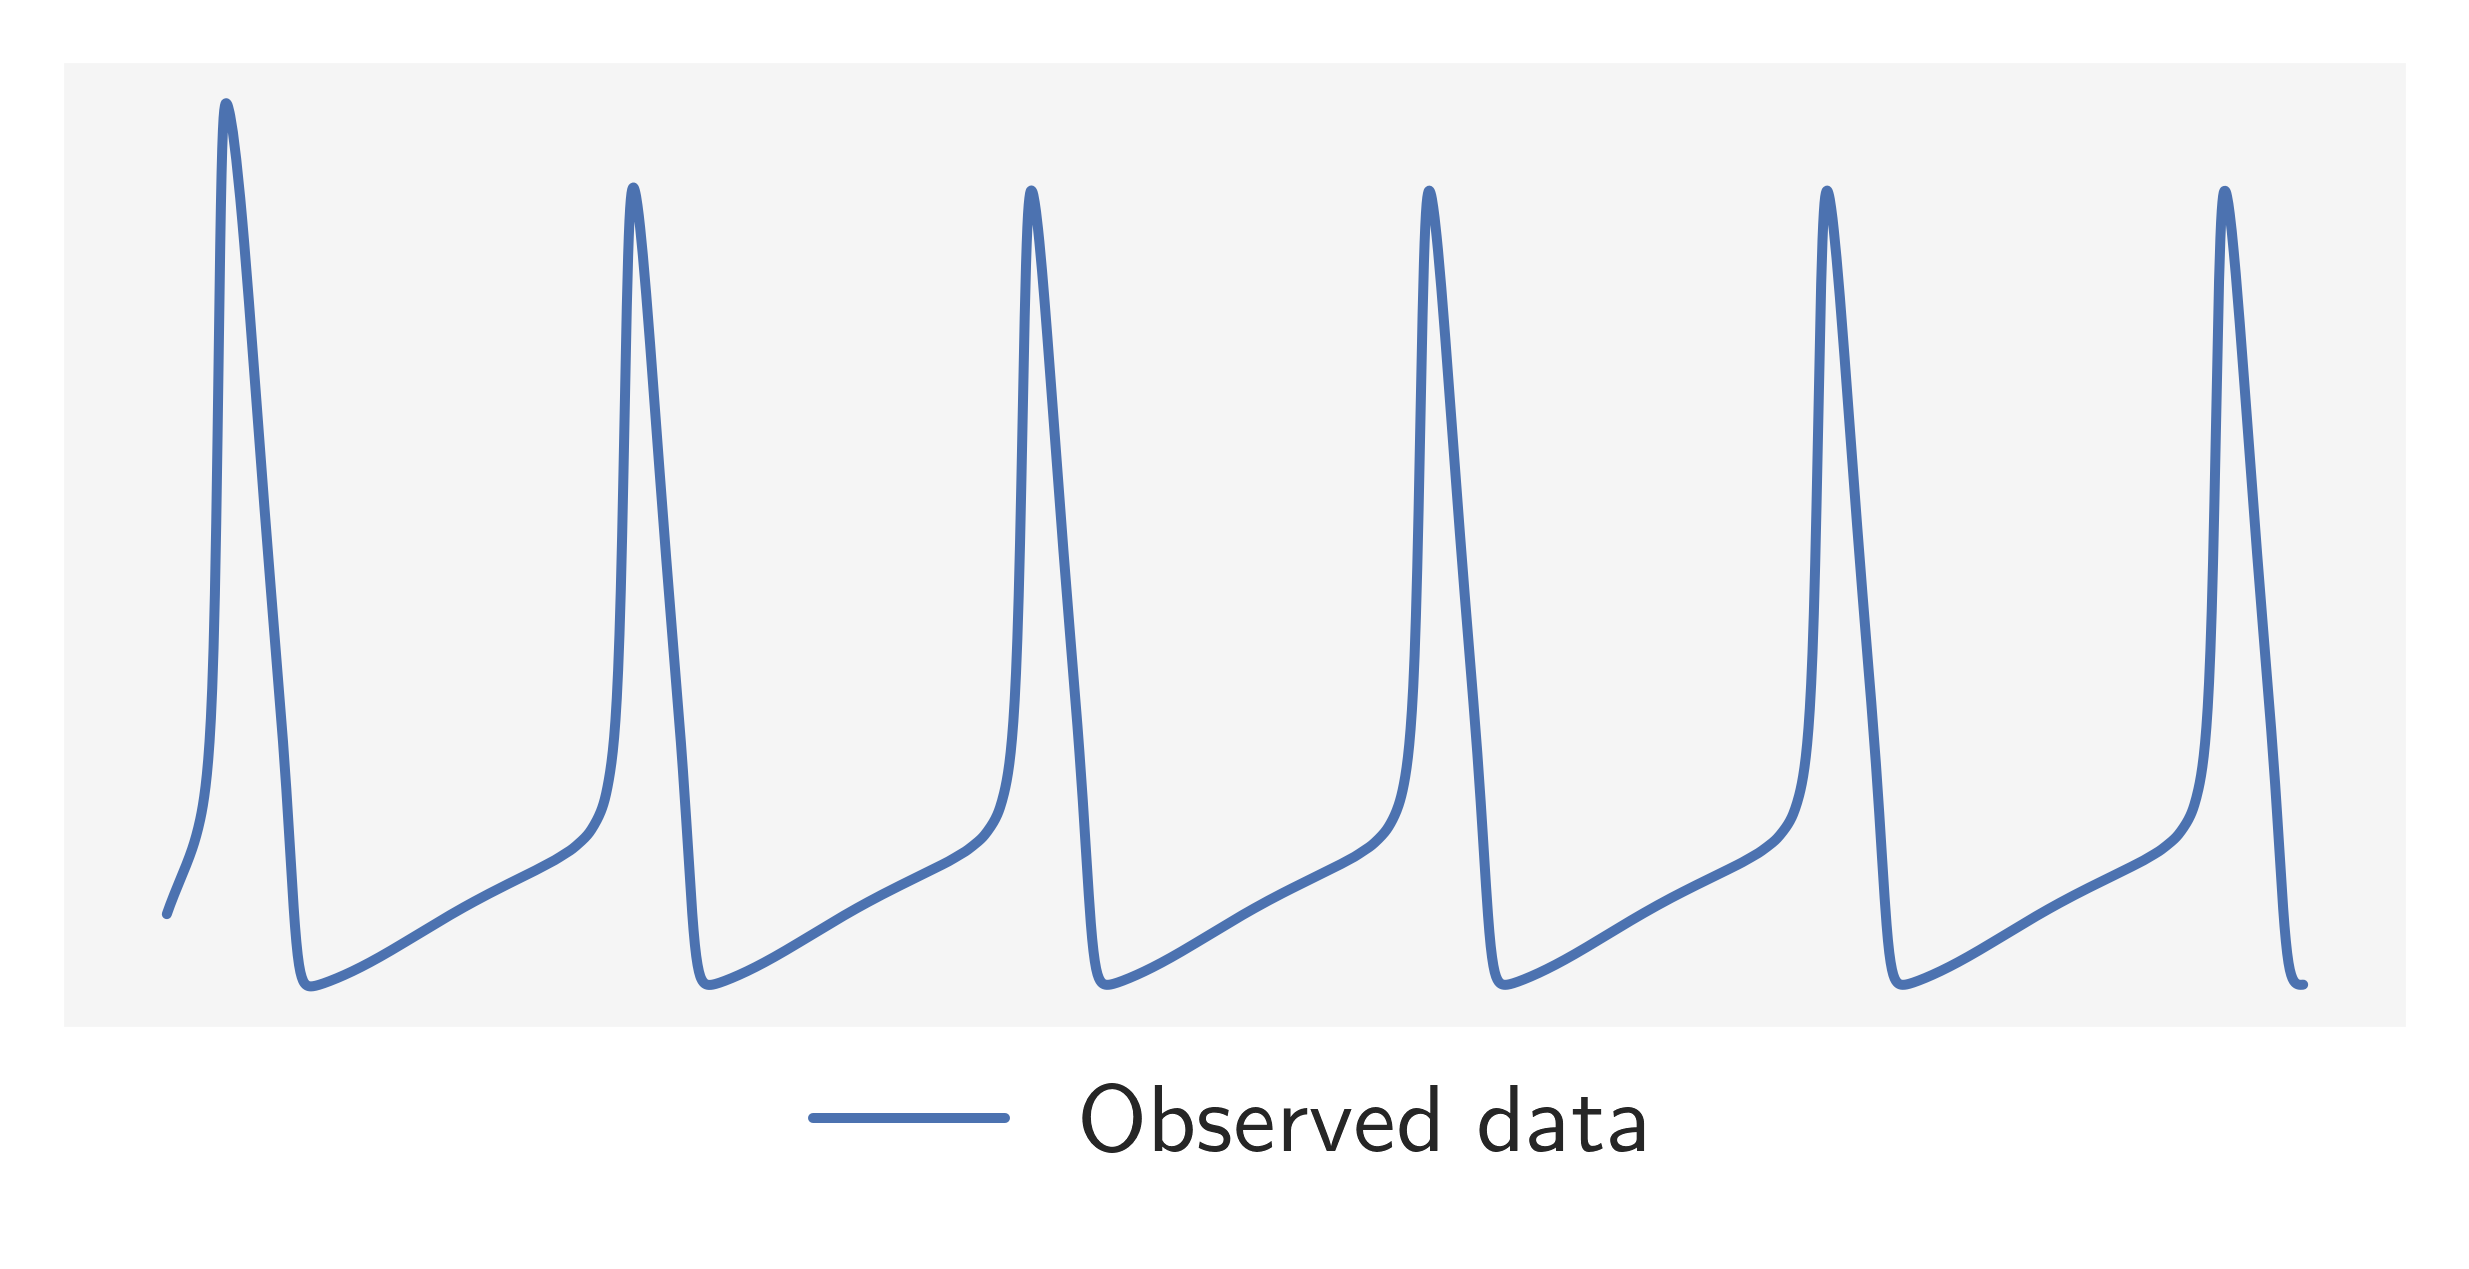

In [13]:
# Simulator model
T = 80           # Simulation time [ms]
dt = 0.025        # Time step [ms]
I_amp = 10        # Input stimuls amplitude [microA/cm^2]
t_stim_on = 0    # Stimulus onset [ms]
t_stim_off = 80  # Stimulus offset [ms]
stimulus = nm.stimulus.Constant(I_amp, t_stim_on, t_stim_off)
hh = nm.models.HodgkinHuxley(stimulus, T, dt) 

params = [36., 120.]
V, t = hh(*params)

params_sim = [30., 115.]
V_sim, t_sim = hh(*params_sim)

fig, ax = plt.subplots(figsize=(4, 2), constrained_layout=True, dpi=300)


ax.plot(t, V, label='Observed data')

ax.set(xticks=[], yticks=[])
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    loc='center left',
    bbox_to_anchor=(0.3, -.1),
    fancybox=True,
    borderaxespad=0.1,
    ncol=1,
    frameon=False
)

#fig.savefig('obs_data_fig.pdf', format='pdf', dpi=300, bbox_inches='tight')

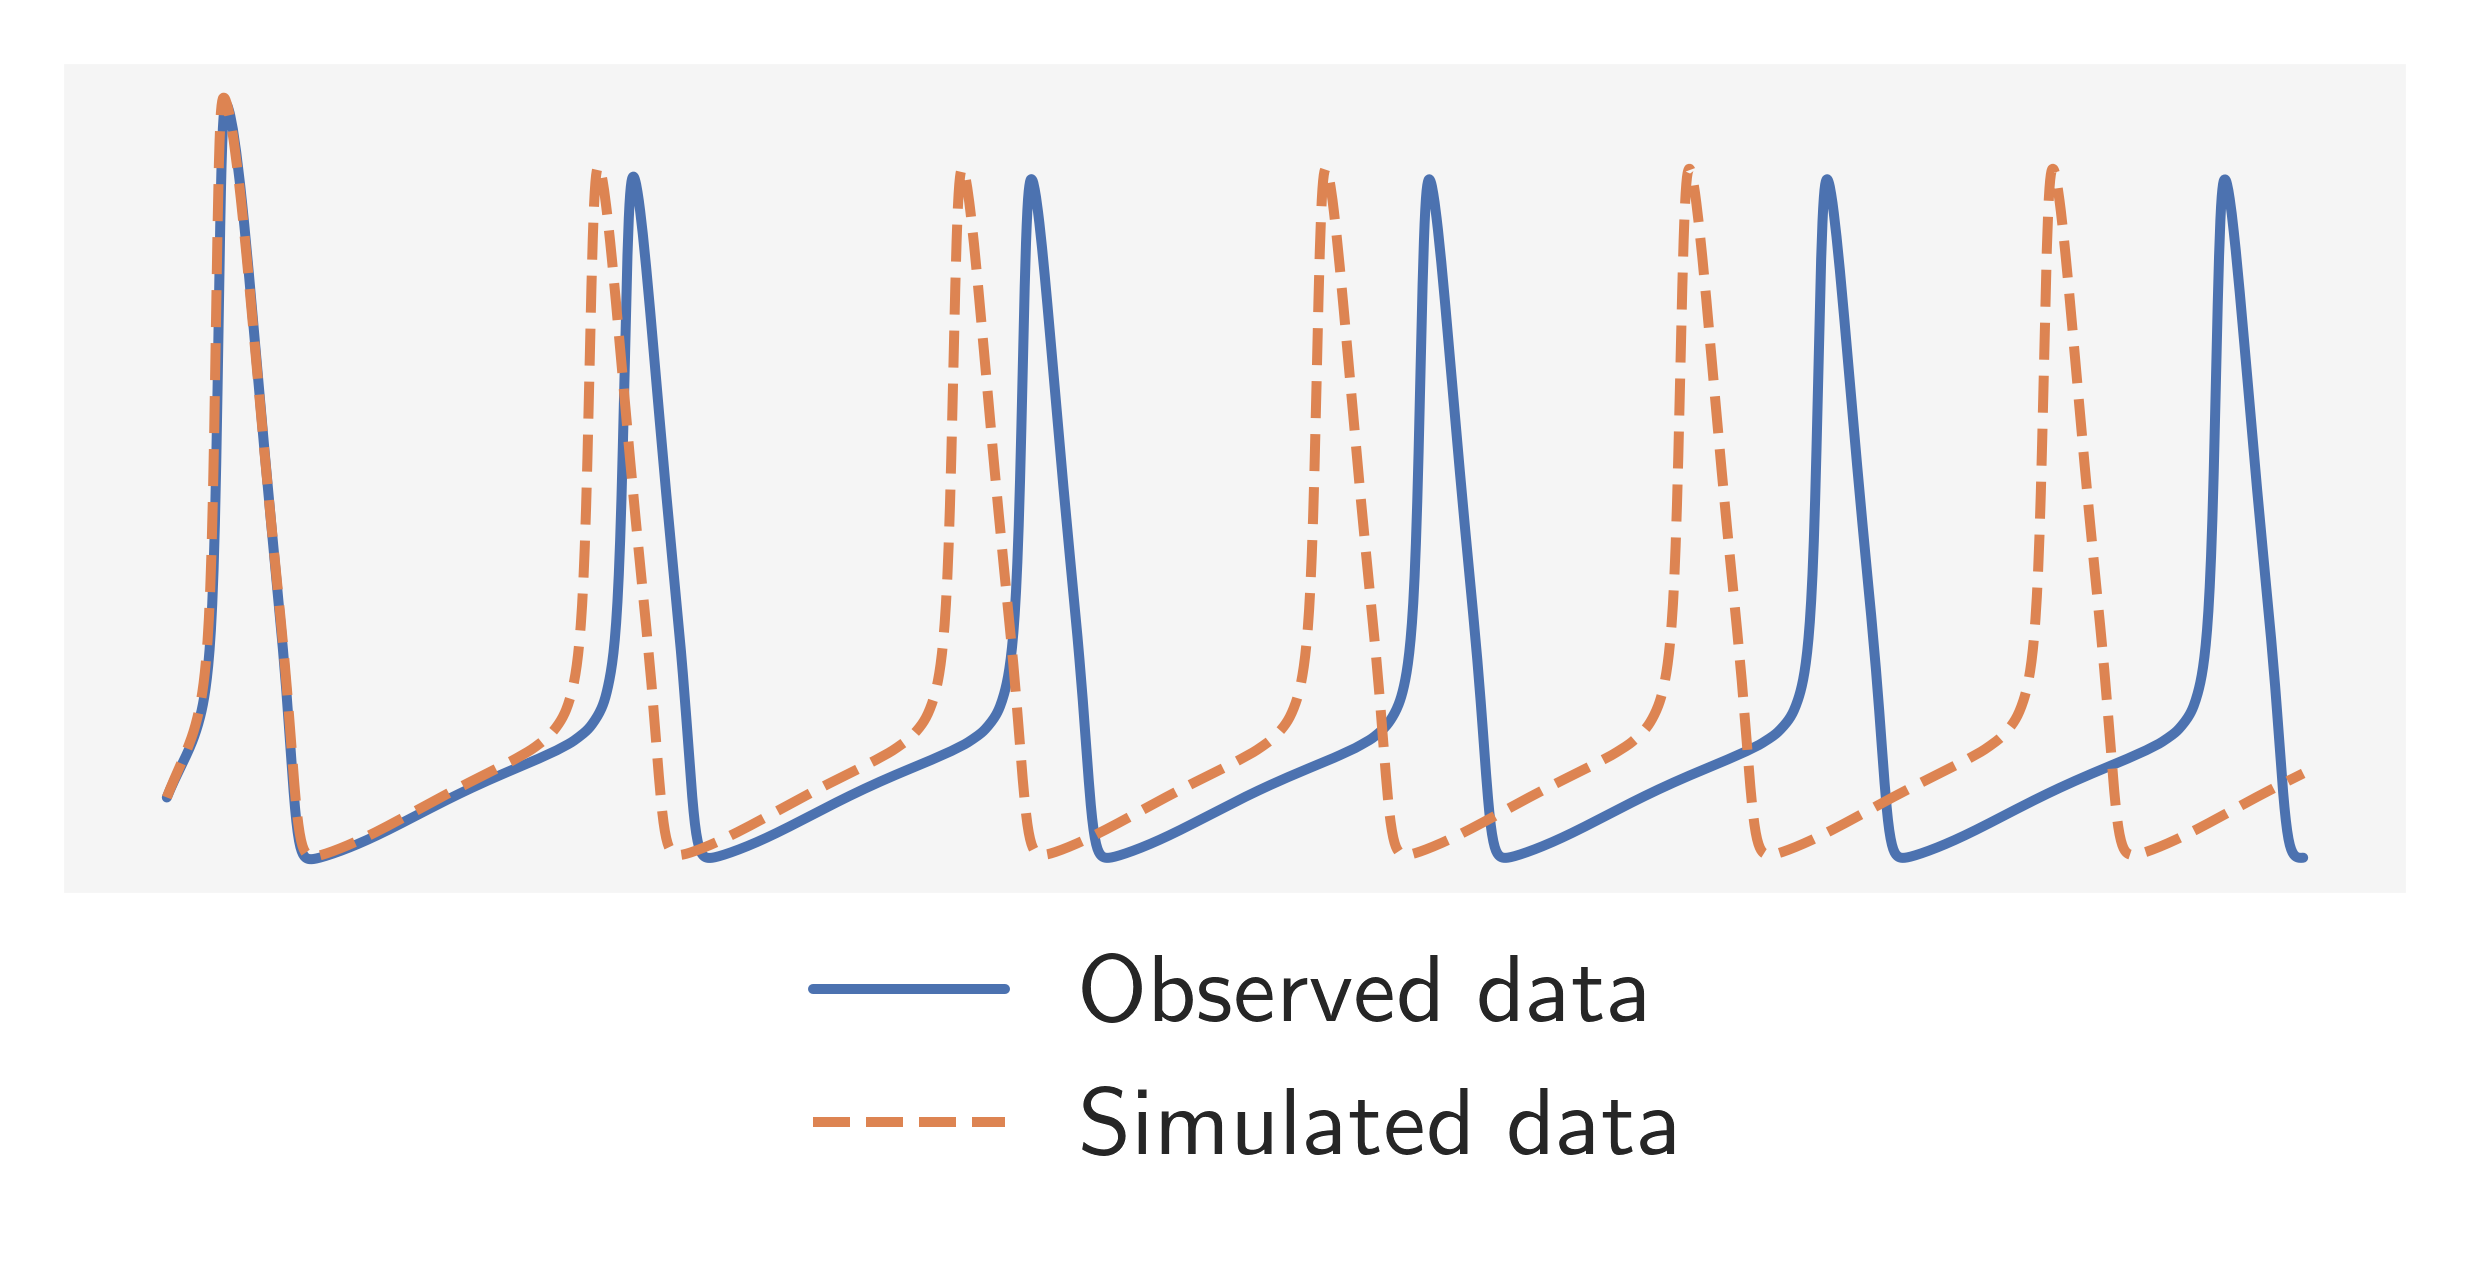

In [14]:
fig, ax = plt.subplots(figsize=(4, 2), constrained_layout=True, dpi=300)


ax.plot(t, V, label='Observed data')
ax.plot(t_sim, V_sim, '--', label='Simulated data')

ax.set(xticks=[], yticks=[])
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    loc='center left',
    #bbox_to_anchor=(1.04, 0.5),
    bbox_to_anchor=(0.3, -.2),
    fancybox=True,
    borderaxespad=0.1,
    ncol=1,
    frameon=False
)

fig.savefig('obs_sim_data_fig.pdf', format='pdf', dpi=300, bbox_inches='tight')

\begin{equation}
    \pi \left( \theta \mid y_\mathrm{obs} \right) = \frac{p \left(y_\mathrm{obs} \mid \theta \right) \pi (\theta)}{p \left(y_\mathrm{obs} \right)}
\end{equation}

## Spike Statistics

In [26]:
# Simulator model
T = 120           # Simulation time [ms]
dt = 0.025        # Time step [ms]
I_amp = 10        # Input stimuls amplitude [microA/cm^2]
t_stim_on = 10    # Stimulus onset [ms]
t_stim_off = 110  # Stimulus offset [ms]
stimulus = nm.stimulus.Constant(I_amp, t_stim_on, t_stim_off)
hh = nm.models.HodgkinHuxley(stimulus, T, dt)
V, t = hh(36.0, 120.0)

sps = nm.SpikeStats(t_stim_on, t_stim_off, threshold, rfp=3.)
spikes = sps.find_spikes(V, t)
n_spikes = spikes["n_spikes"]

spike_idxs = spikes["spike_idxs"]
spike_heights = spikes["spike_heights"]
width_lines = sps.width_lines(V, t)
ahp_depth_idxs = sps.AHP_depth_positions(V, t)

### Voltage trace

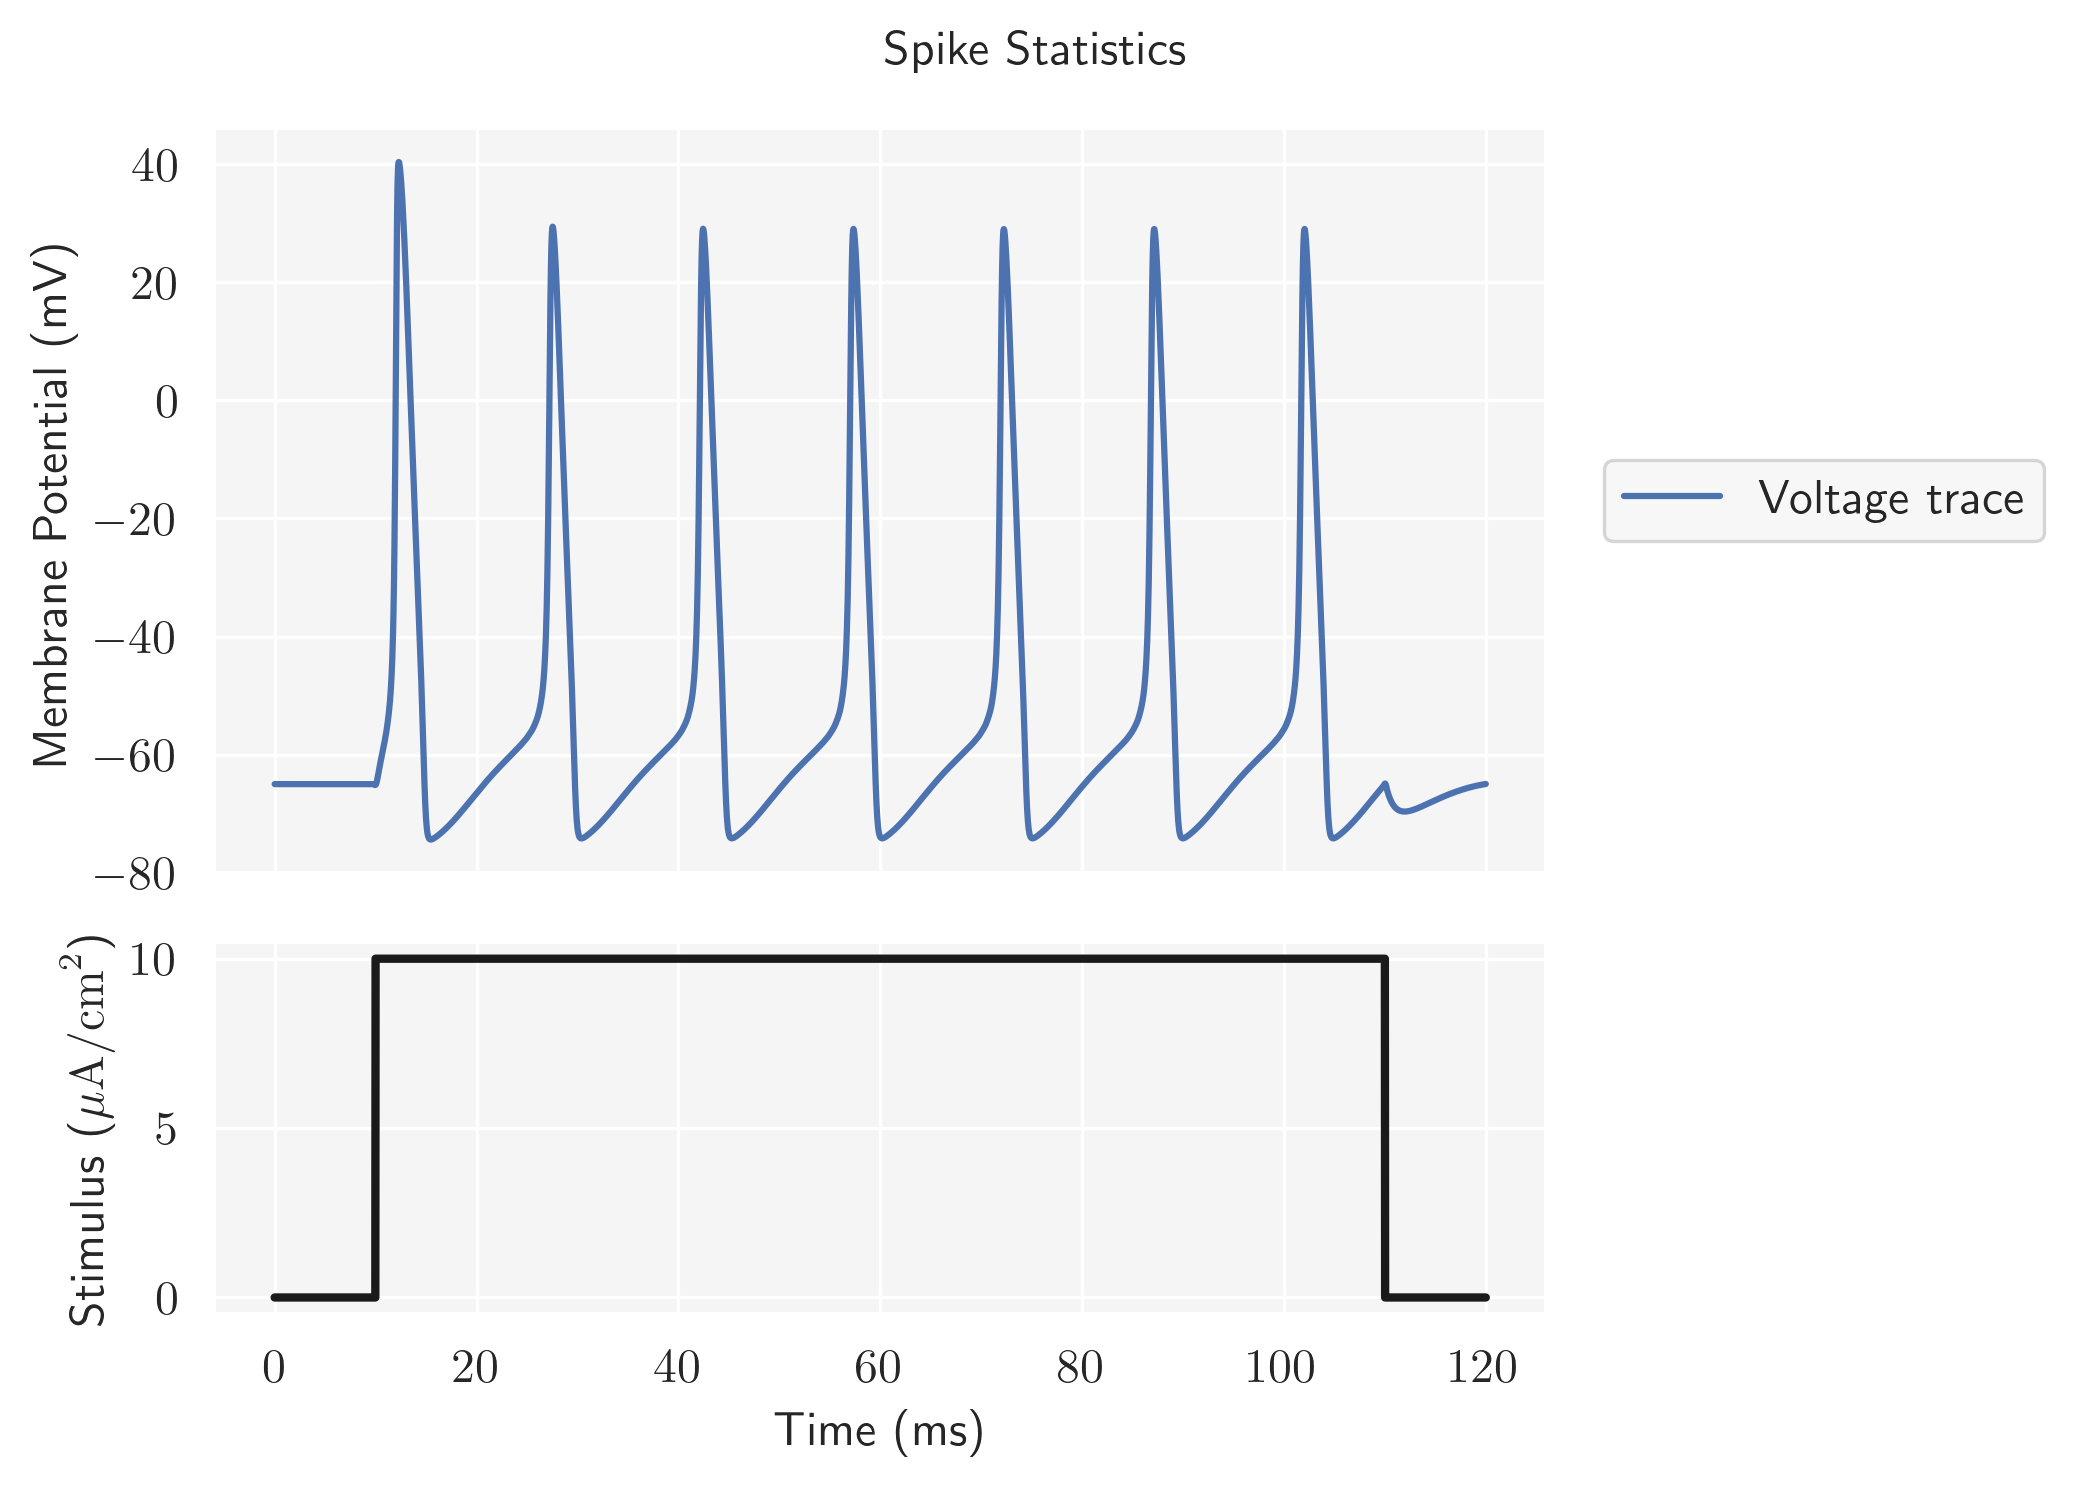

In [27]:
threshold=0
figsize=(7, 5)
dpi=150

# Figure
fig = plt.figure(figsize=figsize, tight_layout=True, dpi=dpi)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 2])
ax0 = plt.subplot(gs[0])

# voltage trace
ax0.plot(t, V, lw=1.5, label='Voltage trace')


ax0.set_ylabel('Membrane Potential (mV)')
ax0.axes.xaxis.set_ticklabels([])


# Rest
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, loc='center left', bbox_to_anchor=(1.04, 0.5), 
           fancybox=True, borderaxespad=0.1, ncol=1, frameon=True)

ax1 = plt.subplot(gs[1])

stim_array = np.array([stimulus(ti) for ti in t])
ax1.plot(t, stim_array, 'k', lw=2)
ax1.set(xlabel='Time (ms)', ylabel=r'Stimulus ($\mu \mathrm{A/cm}^2$)')

fig.suptitle("Spike Statistics")

fig.savefig('sumstats0.pdf', format='pdf', dpi=300, bbox_inches='tight')

### Spike rate

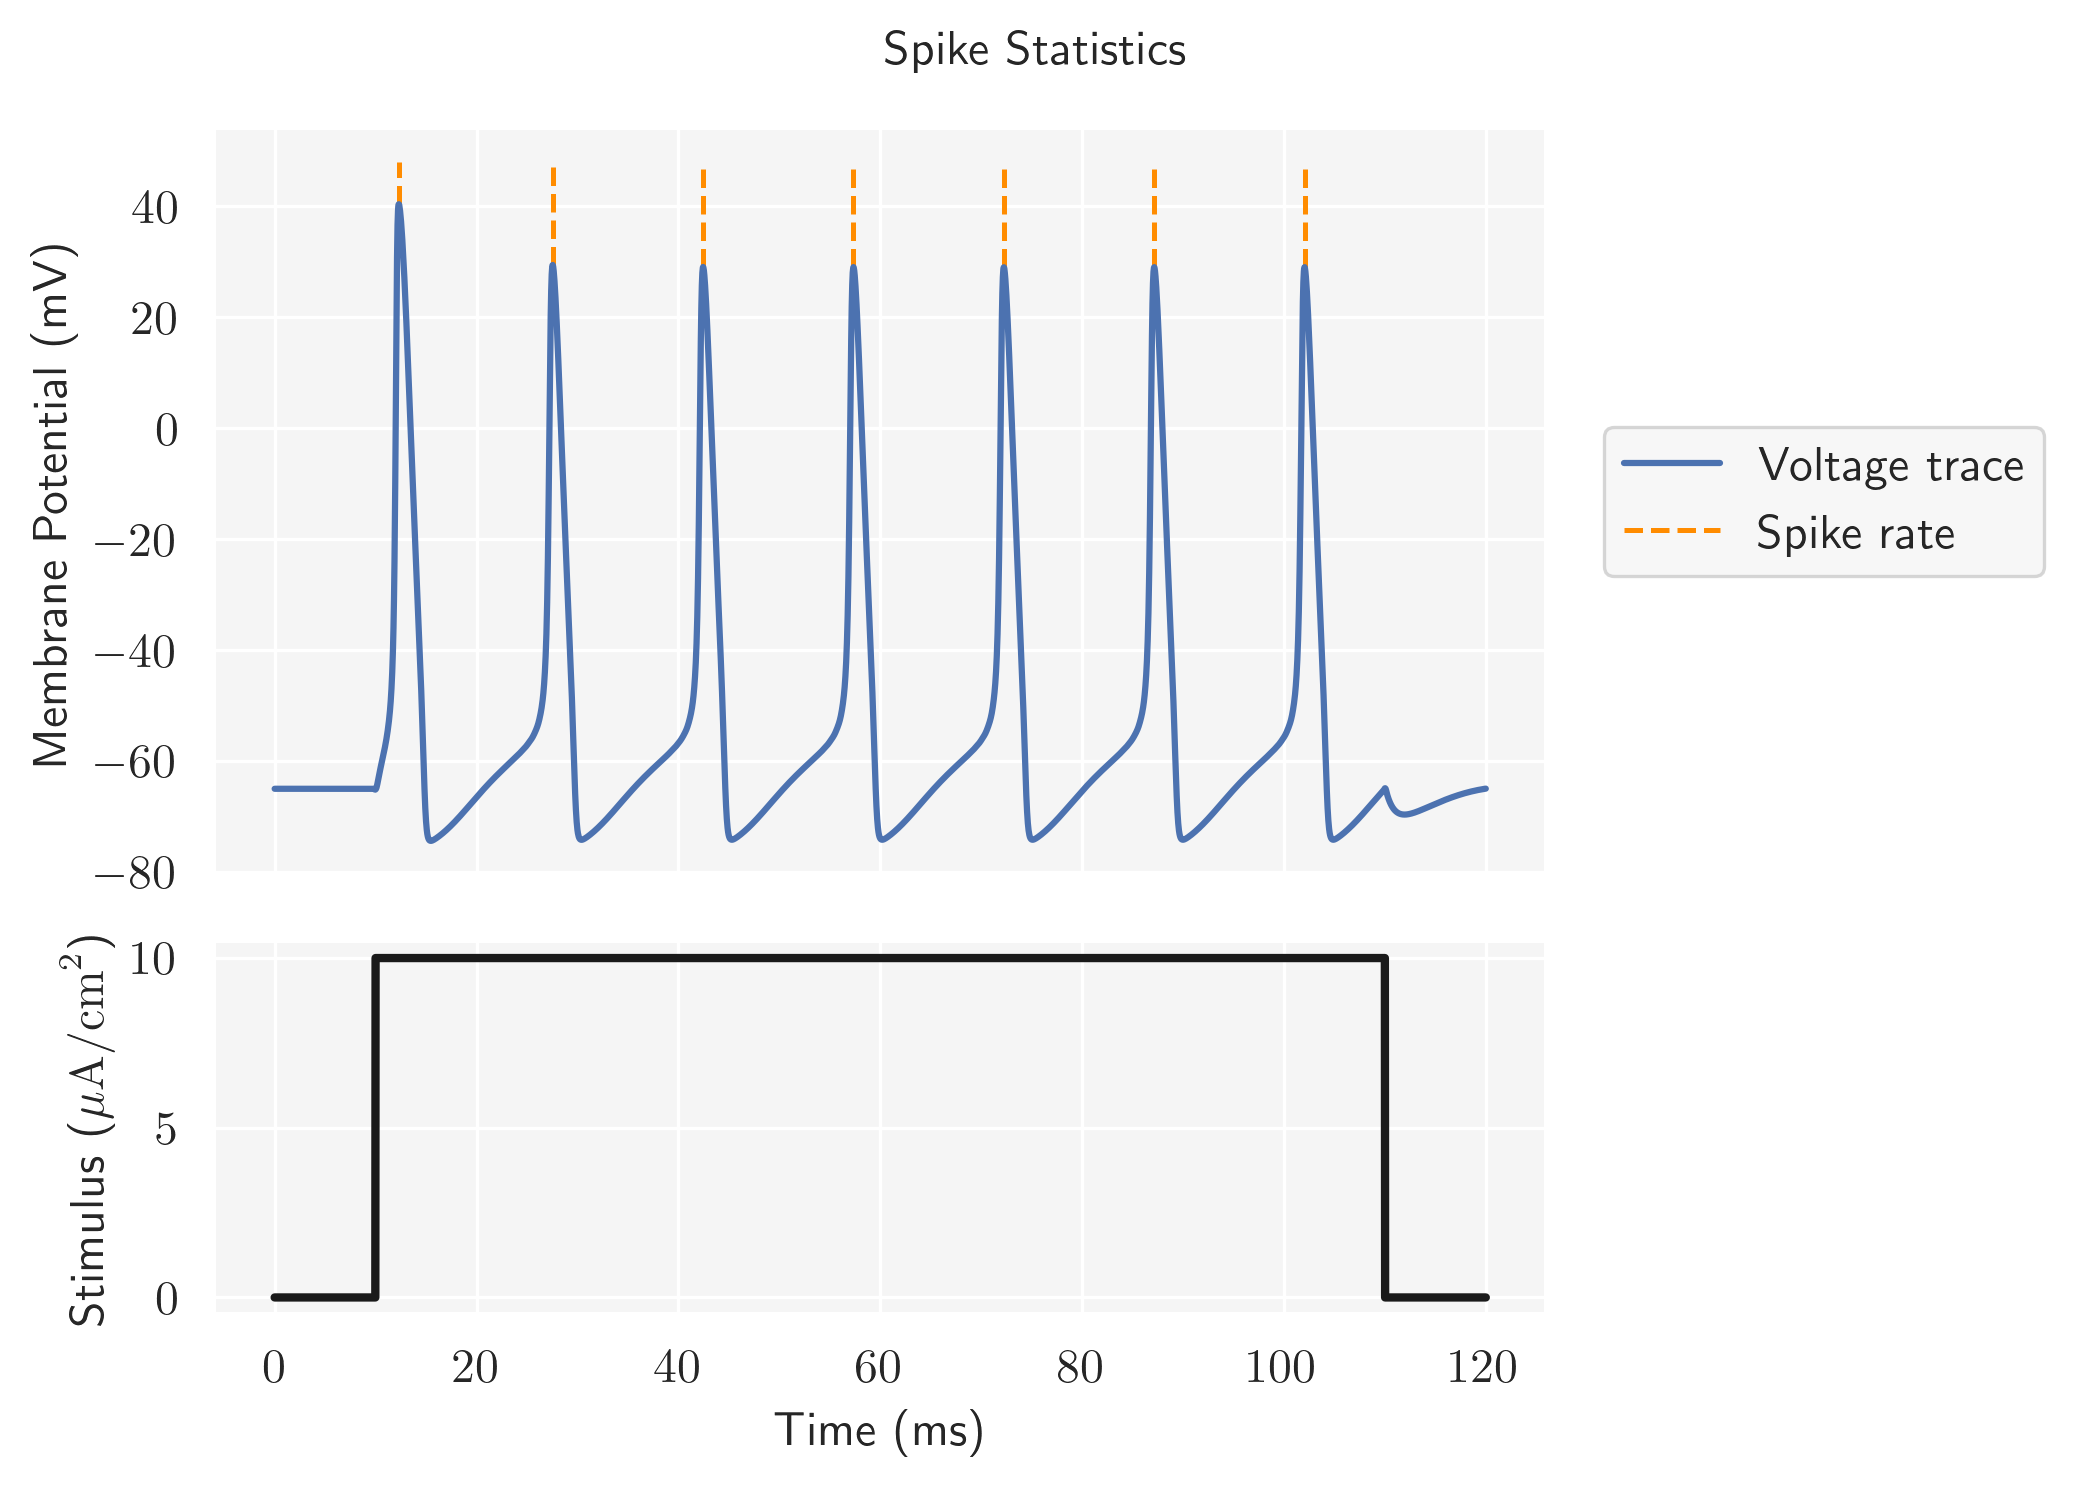

In [29]:
# Figure
fig = plt.figure(figsize=figsize, tight_layout=True, dpi=dpi)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 2])
ax0 = plt.subplot(gs[0])

# voltage trace
ax0.plot(t, V, lw=1.5, label='Voltage trace')

# spike rate; mark spike locations
for i in range(n_spikes):
    if i == 0:
        ax0.vlines(t[spike_idxs[i]], V[spike_idxs[i]], 48, color='darkorange', ls='--', label='Spike rate')
    else:
        ax0.vlines(t[spike_idxs[i]], V[spike_idxs[i]], 48, color='darkorange', ls='--')

# AP overshoot
#ax0.plot(t[spike_idxs], V[spike_idxs], "x", ms=7, color='black', label='AP overshoot')


# Rest
ax0.set_ylabel('Membrane Potential (mV)')
ax0.axes.xaxis.set_ticklabels([])

handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, loc='center left', bbox_to_anchor=(1.04, 0.5), 
           fancybox=True, borderaxespad=0.1, ncol=1, frameon=True)

ax1 = plt.subplot(gs[1])

stim_array = np.array([stimulus(ti) for ti in t])
ax1.plot(t, stim_array, 'k', lw=2)
ax1.set(xlabel='Time (ms)', ylabel=r'Stimulus ($\mu \mathrm{A/cm}^2$)')

fig.suptitle("Spike Statistics")

fig.savefig('sumstats1.pdf', format='pdf', dpi=300, bbox_inches='tight')

### AP overshoot

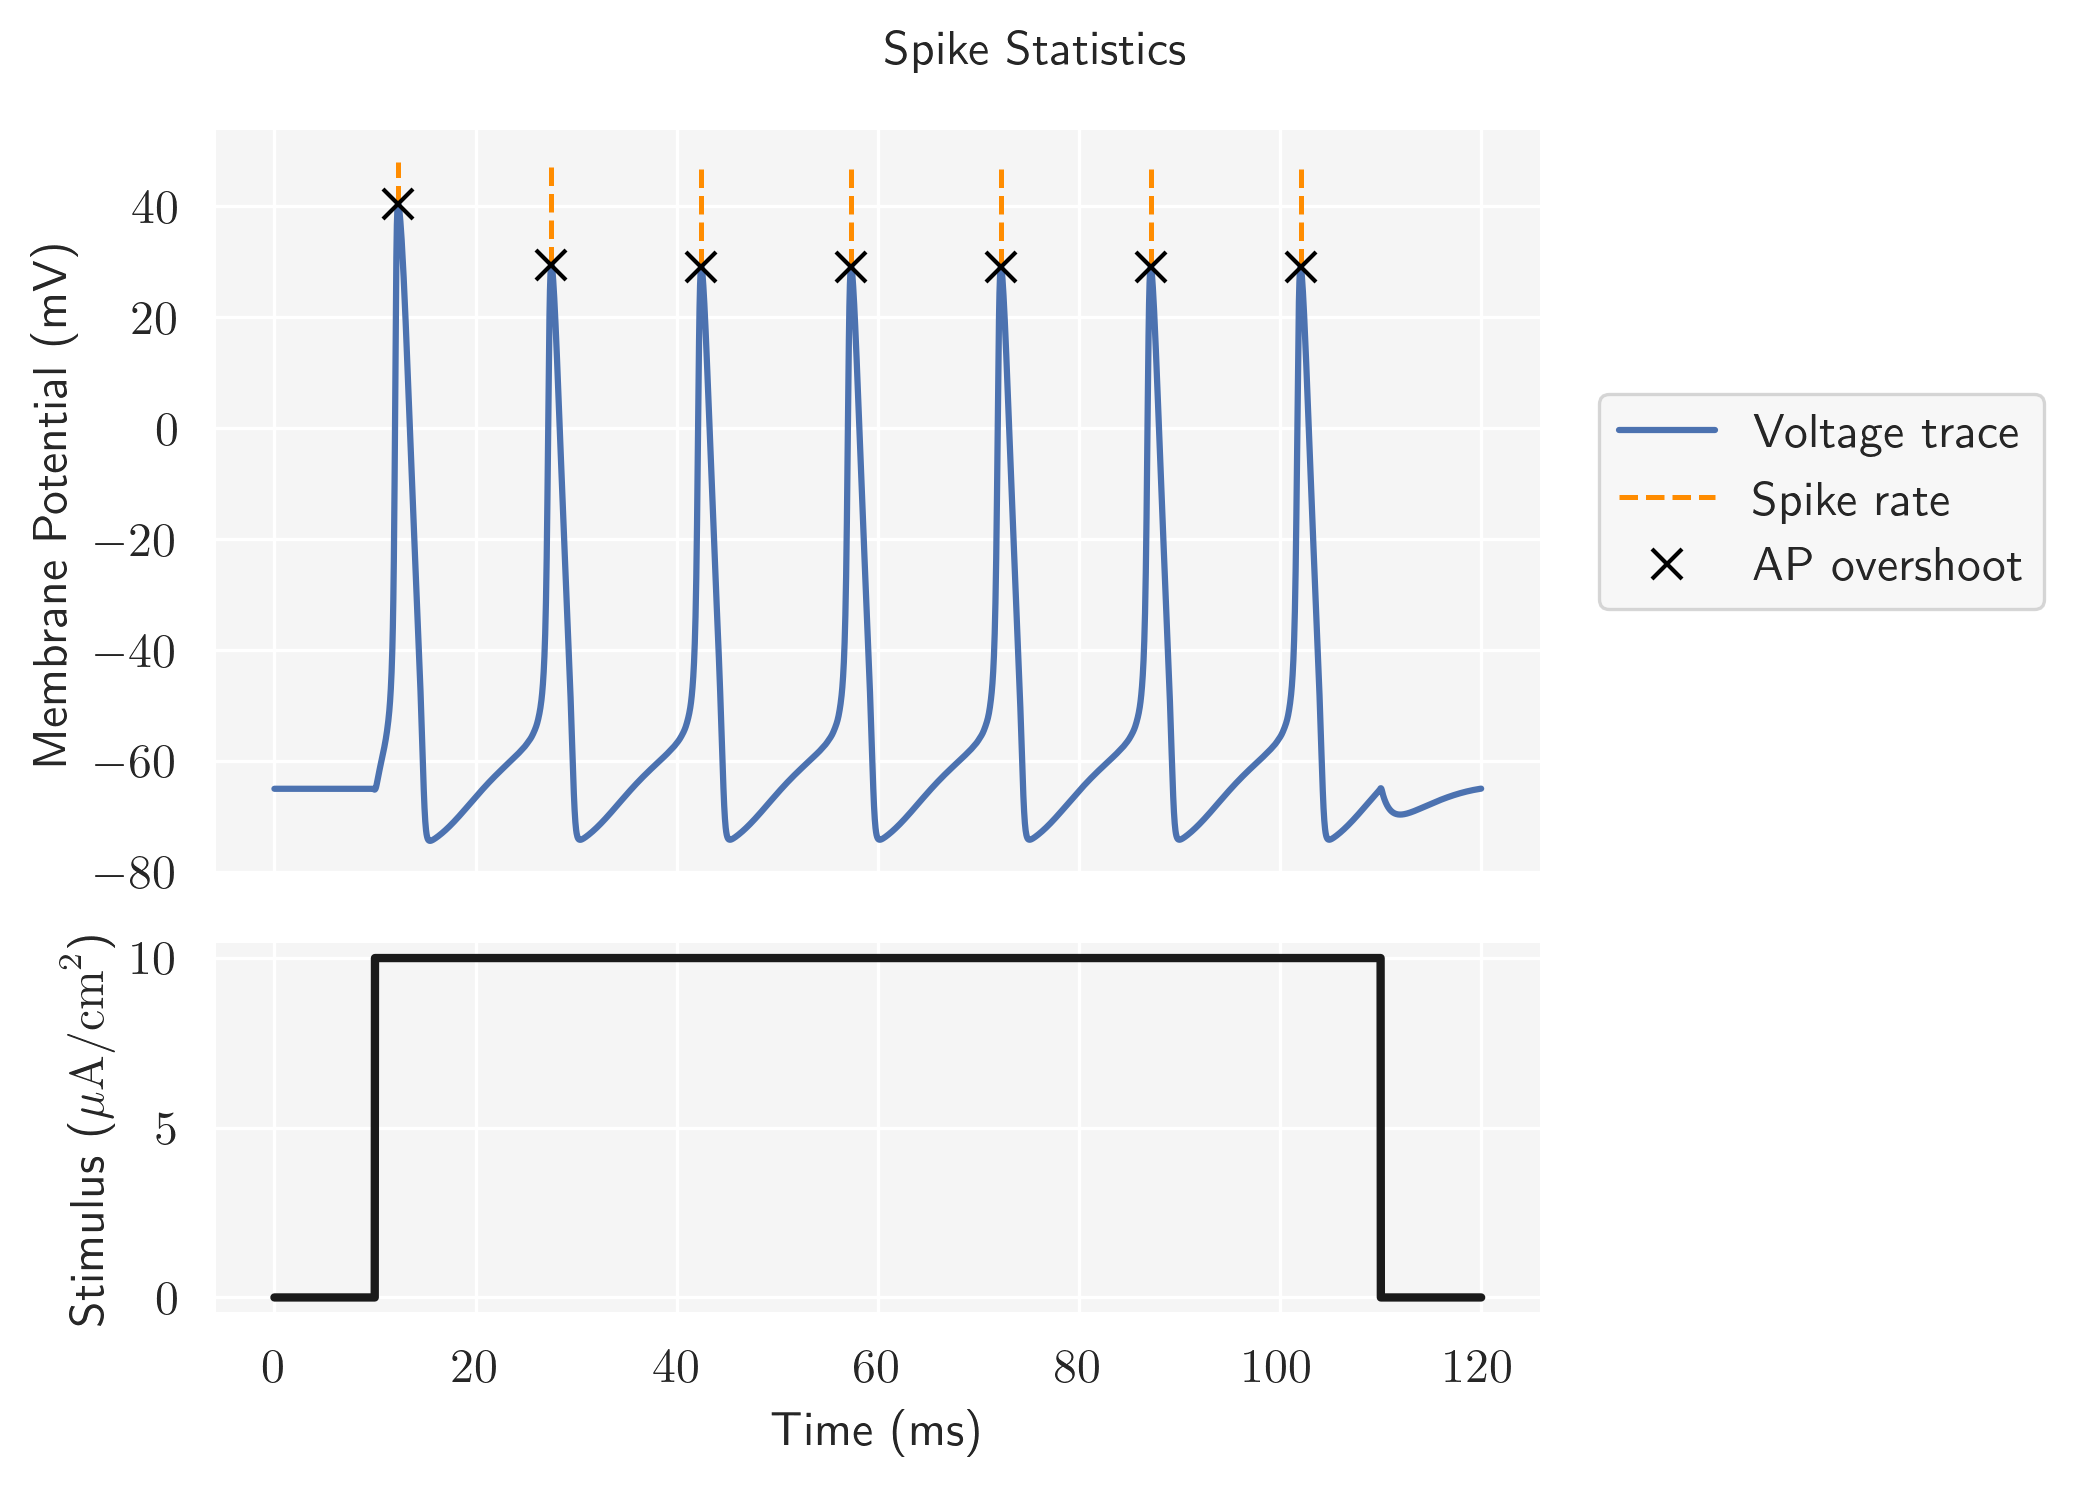

In [34]:
# Figure
fig = plt.figure(figsize=figsize, tight_layout=True, dpi=dpi)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 2])
ax0 = plt.subplot(gs[0])

# voltage trace
ax0.plot(t, V, lw=1.5, label='Voltage trace')

# spike rate; mark spike locations
for i in range(n_spikes):
    if i == 0:
        ax0.vlines(t[spike_idxs[i]], V[spike_idxs[i]], 48, color='darkorange', ls='--', label='Spike rate')
    else:
        ax0.vlines(t[spike_idxs[i]], V[spike_idxs[i]], 48, color='darkorange', ls='--')

# AP overshoot
ax0.plot(t[spike_idxs], V[spike_idxs], "x", ms=7, color='black', label='AP overshoot')


# Rest
ax0.set_ylabel('Membrane Potential (mV)')
ax0.axes.xaxis.set_ticklabels([])

handles, labels = ax0.get_legend_handles_labels()
order = [0, 2, 1]
ax0.legend([handles[idx] for idx in order], [labels[idx] for idx in order], 
           #handels, labels,
           loc='center left', bbox_to_anchor=(1.04, 0.5), 
           fancybox=True, borderaxespad=0.1, ncol=1, frameon=True)

ax1 = plt.subplot(gs[1])

stim_array = np.array([stimulus(ti) for ti in t])
ax1.plot(t, stim_array, 'k', lw=2)
ax1.set(xlabel='Time (ms)', ylabel=r'Stimulus ($\mu \mathrm{A/cm}^2$)')

fig.suptitle("Spike Statistics")

fig.savefig('sumstats2.pdf', format='pdf', dpi=300, bbox_inches='tight')

### AP width

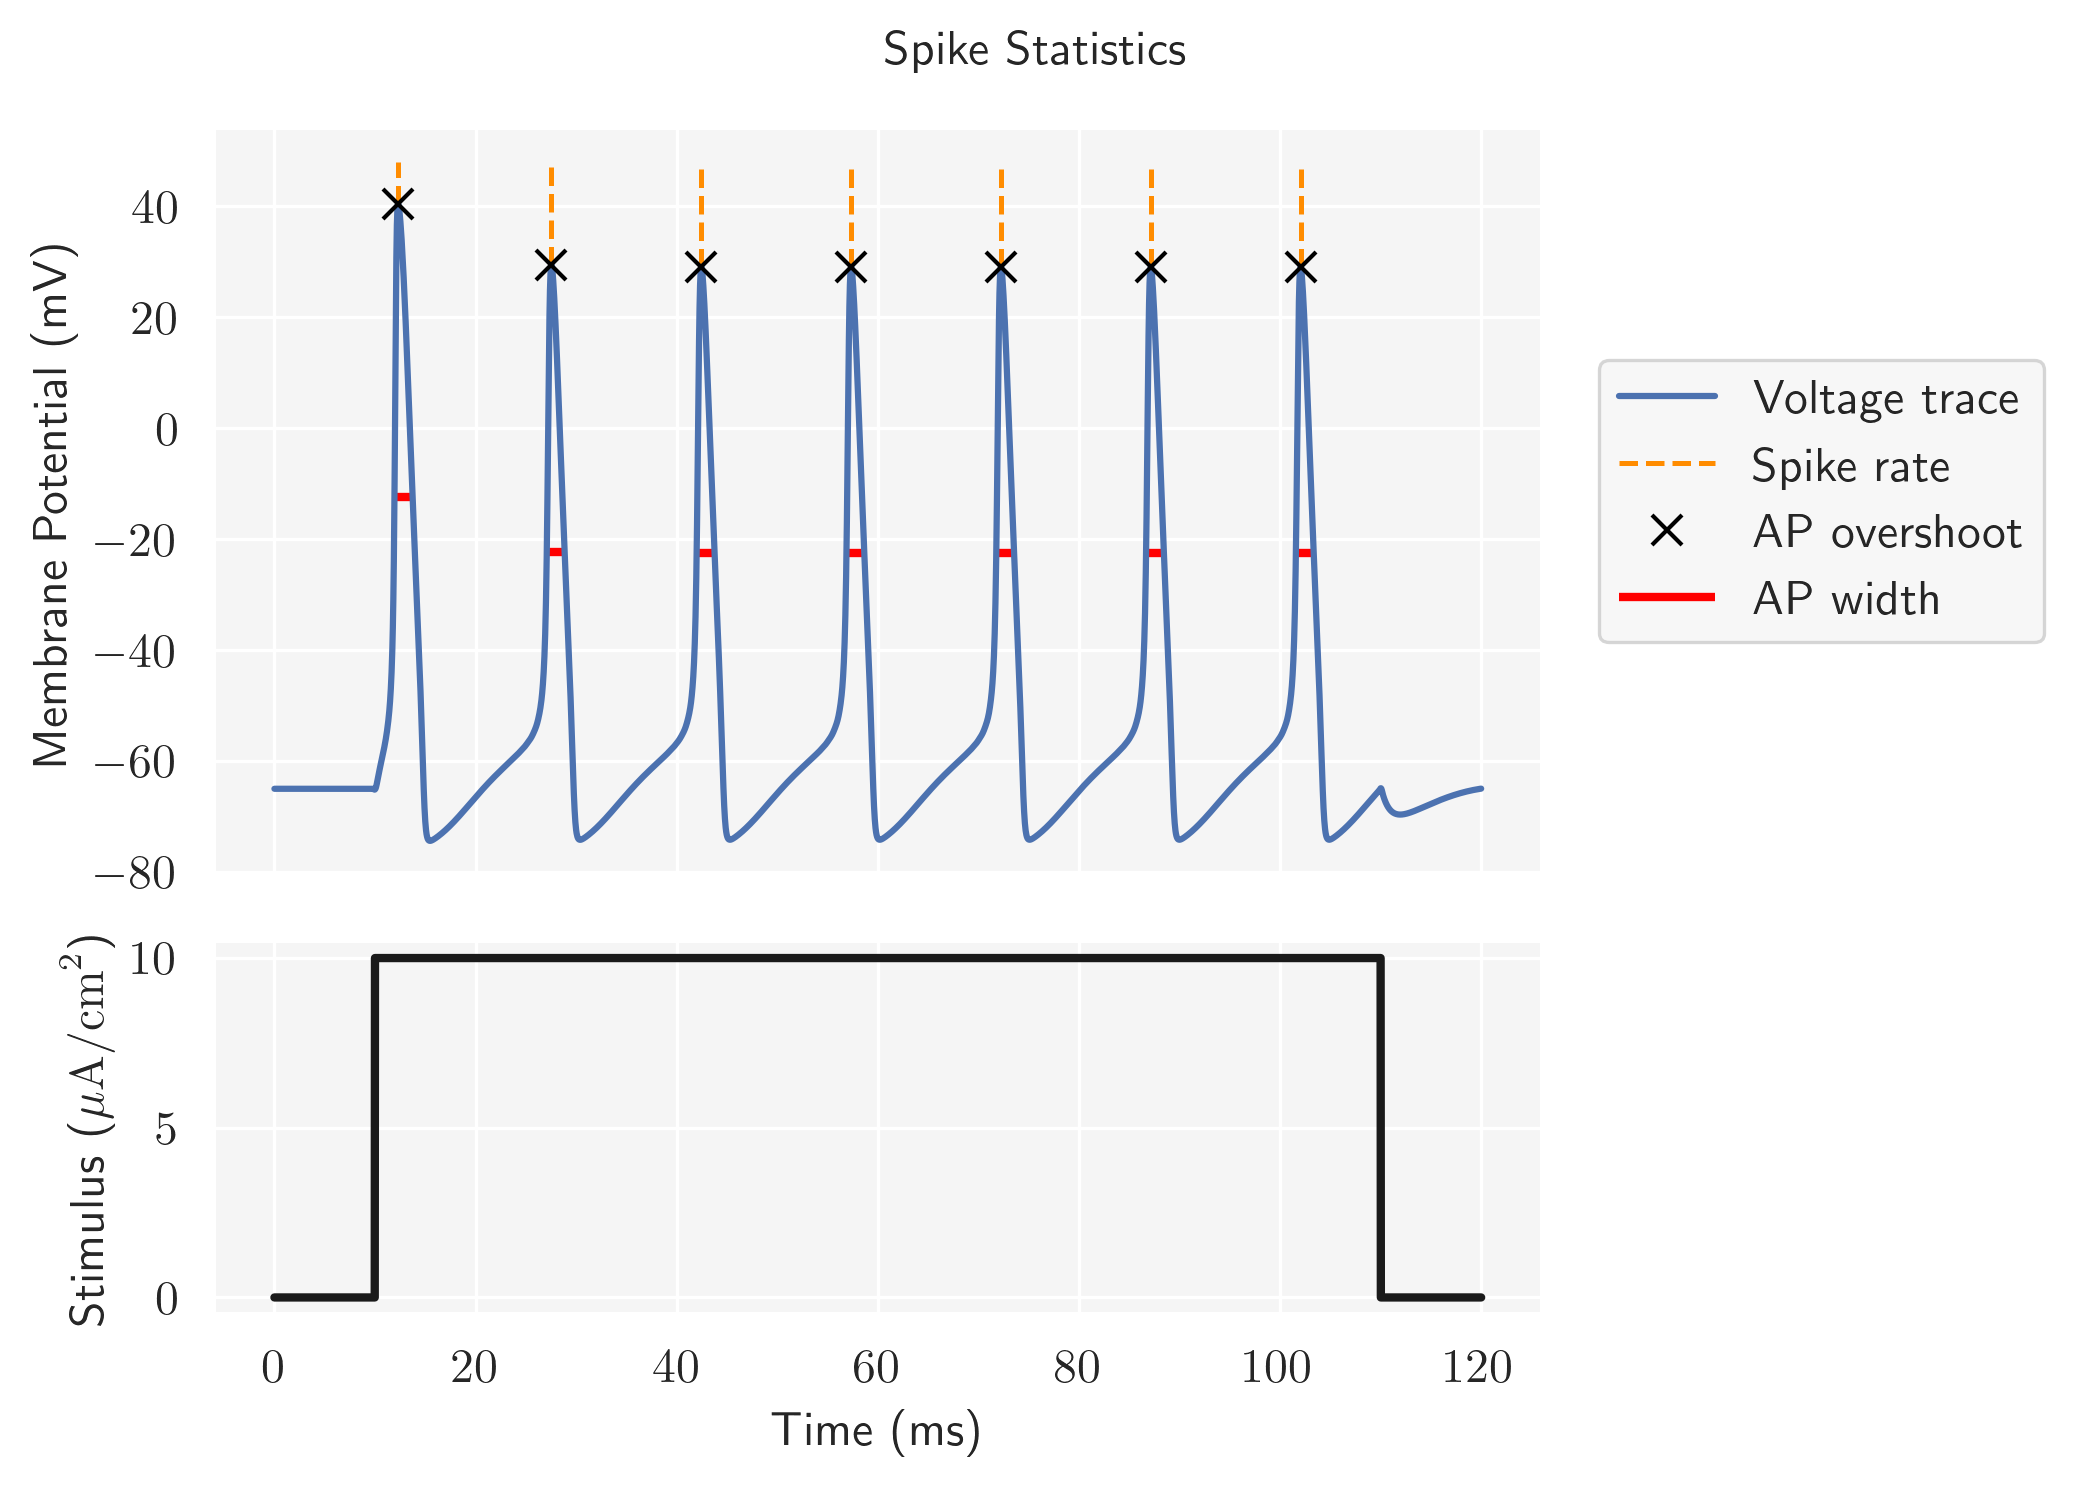

In [35]:
# Figure
fig = plt.figure(figsize=figsize, tight_layout=True, dpi=dpi)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 2])
ax0 = plt.subplot(gs[0])

# voltage trace
ax0.plot(t, V, lw=1.5, label='Voltage trace')

# spike rate; mark spike locations
for i in range(n_spikes):
    if i == 0:
        ax0.vlines(t[spike_idxs[i]], V[spike_idxs[i]], 48, color='darkorange', ls='--', label='Spike rate')
    else:
        ax0.vlines(t[spike_idxs[i]], V[spike_idxs[i]], 48, color='darkorange', ls='--')

# AP overshoot
ax0.plot(t[spike_idxs], V[spike_idxs], "x", ms=7, color='black', label='AP overshoot')

# AP widths
ax0.hlines(*width_lines, color="red", lw=2, label='AP width')


# Rest
ax0.set_ylabel('Membrane Potential (mV)')
ax0.axes.xaxis.set_ticklabels([])

handles, labels = ax0.get_legend_handles_labels()
order = [0, 2, 1, 3]
ax0.legend([handles[idx] for idx in order], [labels[idx] for idx in order], 
           #handles, labels,
           loc='center left', bbox_to_anchor=(1.04, 0.5), 
           fancybox=True, borderaxespad=0.1, ncol=1, frameon=True)

ax1 = plt.subplot(gs[1])

stim_array = np.array([stimulus(ti) for ti in t])
ax1.plot(t, stim_array, 'k', lw=2)
ax1.set(xlabel='Time (ms)', ylabel=r'Stimulus ($\mu \mathrm{A/cm}^2$)')

fig.suptitle("Spike Statistics")

fig.savefig('sumstats3.pdf', format='pdf', dpi=300, bbox_inches='tight')

### AHP depth

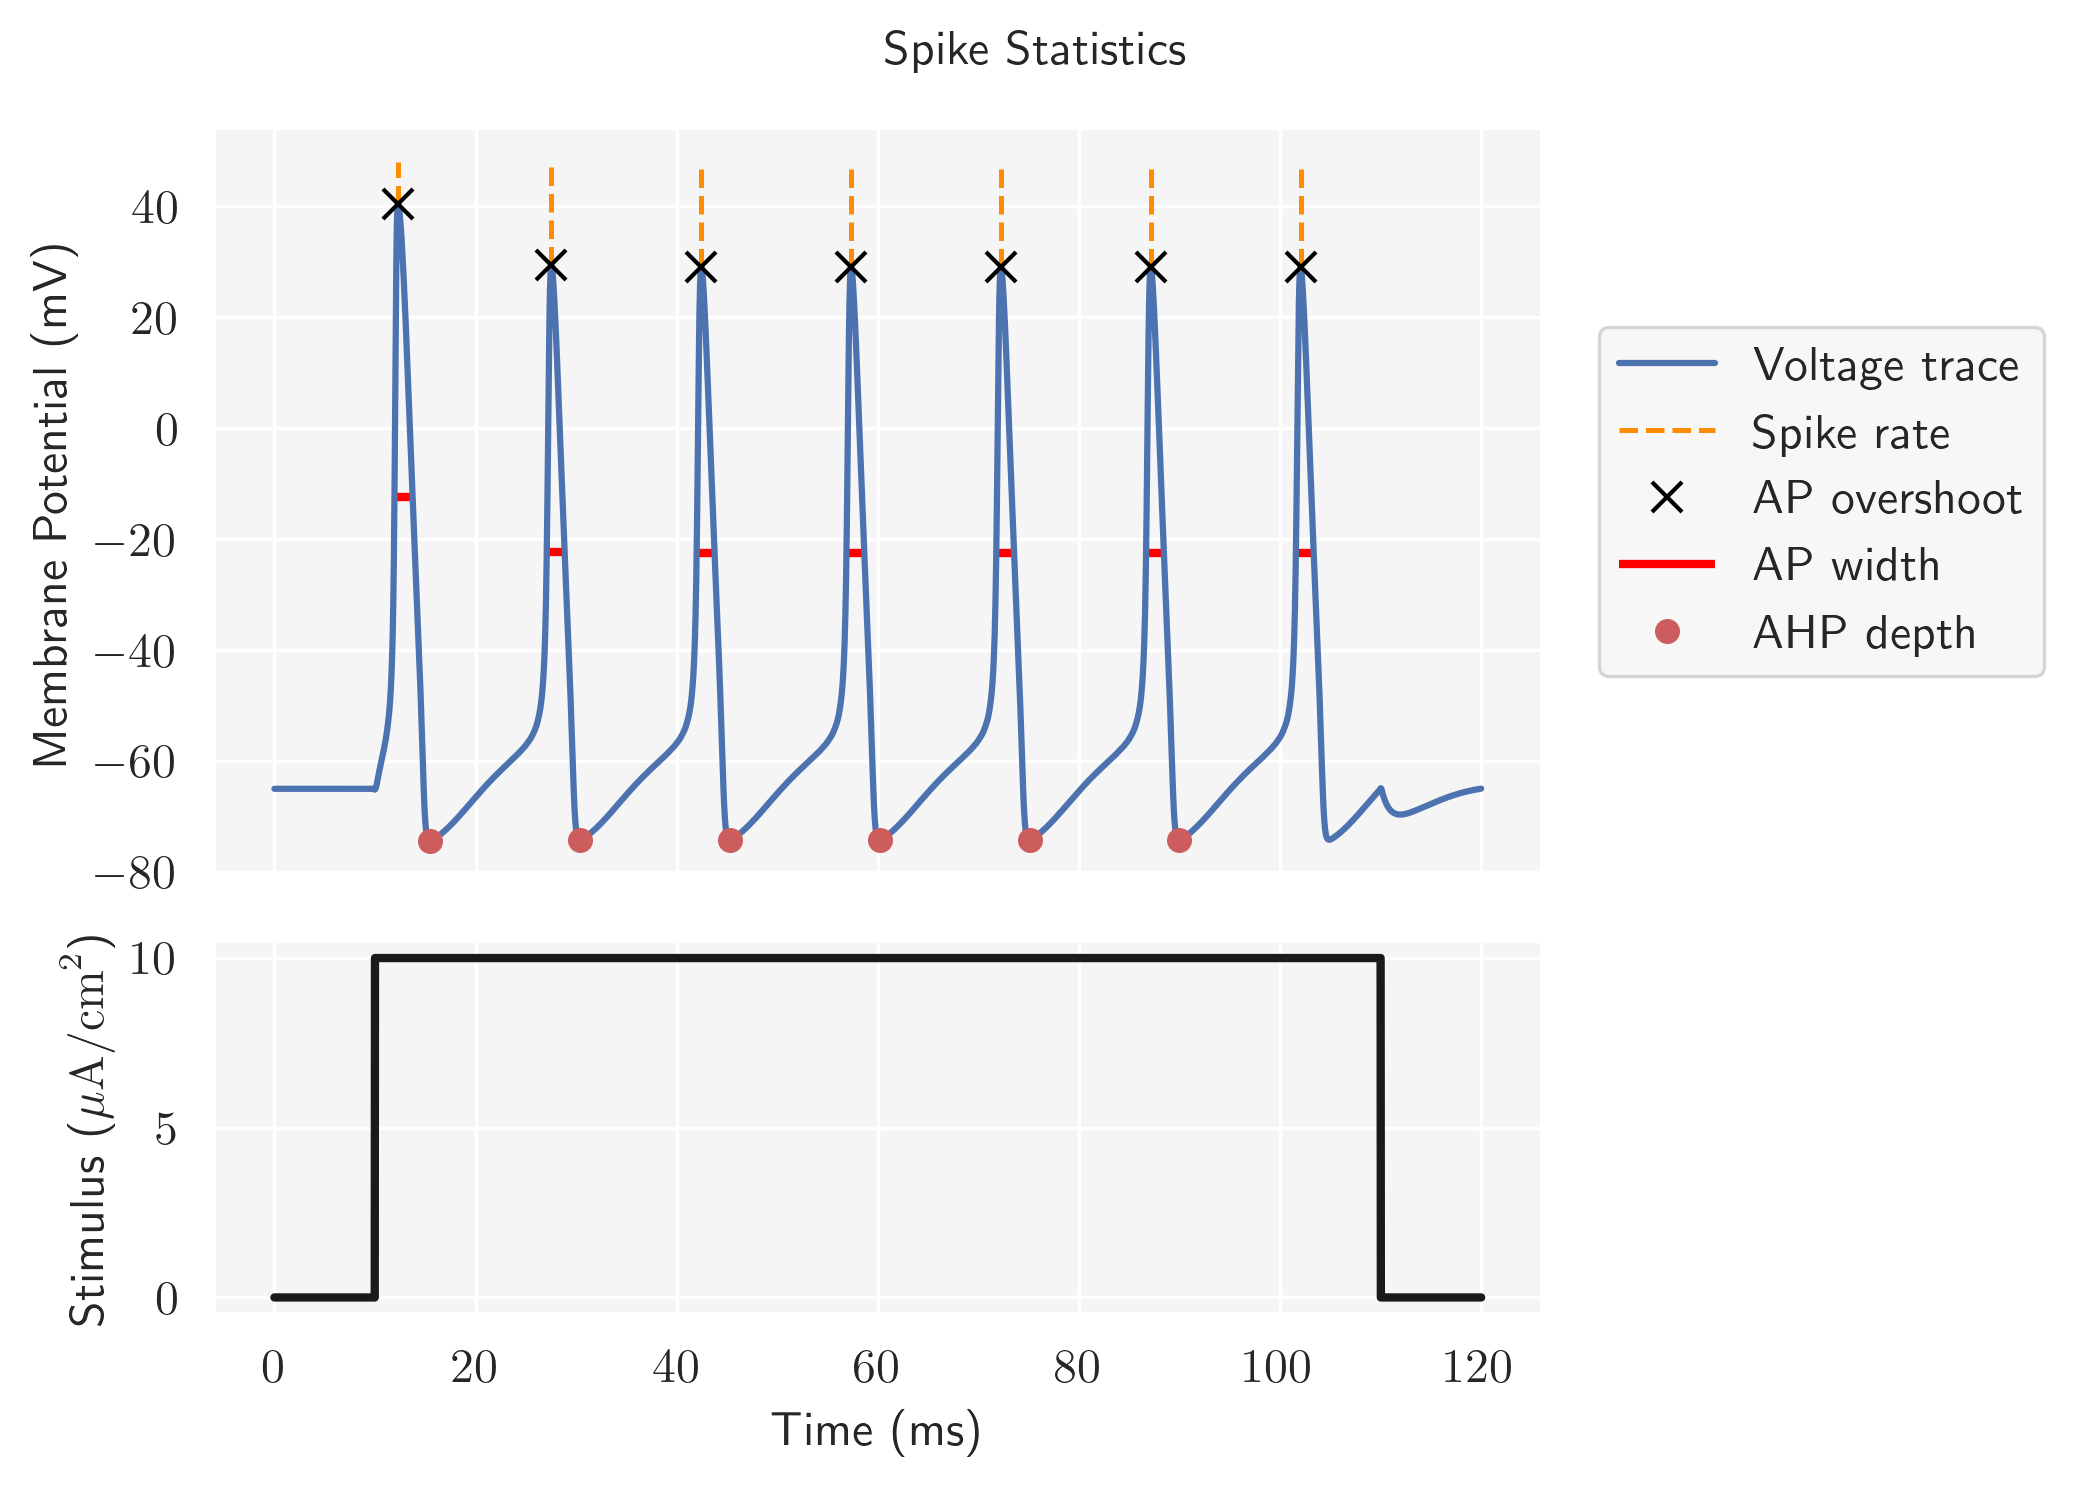

In [37]:
# Figure
fig = plt.figure(figsize=figsize, tight_layout=True, dpi=dpi)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 2])
ax0 = plt.subplot(gs[0])

# voltage trace
ax0.plot(t, V, lw=1.5, label='Voltage trace')

# spike rate; mark spike locations
for i in range(n_spikes):
    if i == 0:
        ax0.vlines(t[spike_idxs[i]], V[spike_idxs[i]], 48, color='darkorange', ls='--', label='Spike rate')
    else:
        ax0.vlines(t[spike_idxs[i]], V[spike_idxs[i]], 48, color='darkorange', ls='--')

# AP overshoot
ax0.plot(t[spike_idxs], V[spike_idxs], "x", ms=7, color='black', label='AP overshoot')

# AP widths
ax0.hlines(*width_lines, color="red", lw=2, label='AP width')

 # AHP depths
ax0.plot(t[ahp_depth_idxs], V[ahp_depth_idxs], 'o', ms=5, color='indianred', label='AHP depth')


# Rest
ax0.set_ylabel('Membrane Potential (mV)')
ax0.axes.xaxis.set_ticklabels([])

handles, labels = ax0.get_legend_handles_labels()
order = [0, 3, 1, 4, 2]
ax0.legend([handles[idx] for idx in order], [labels[idx] for idx in order], 
           #handles, labels,
           loc='center left', bbox_to_anchor=(1.04, 0.5), 
           fancybox=True, borderaxespad=0.1, ncol=1, frameon=True)

ax1 = plt.subplot(gs[1])

stim_array = np.array([stimulus(ti) for ti in t])
ax1.plot(t, stim_array, 'k', lw=2)
ax1.set(xlabel='Time (ms)', ylabel=r'Stimulus ($\mu \mathrm{A/cm}^2$)')

fig.suptitle("Spike Statistics")

fig.savefig('sumstats4.pdf', format='pdf', dpi=300, bbox_inches='tight')

### Latency to first spike

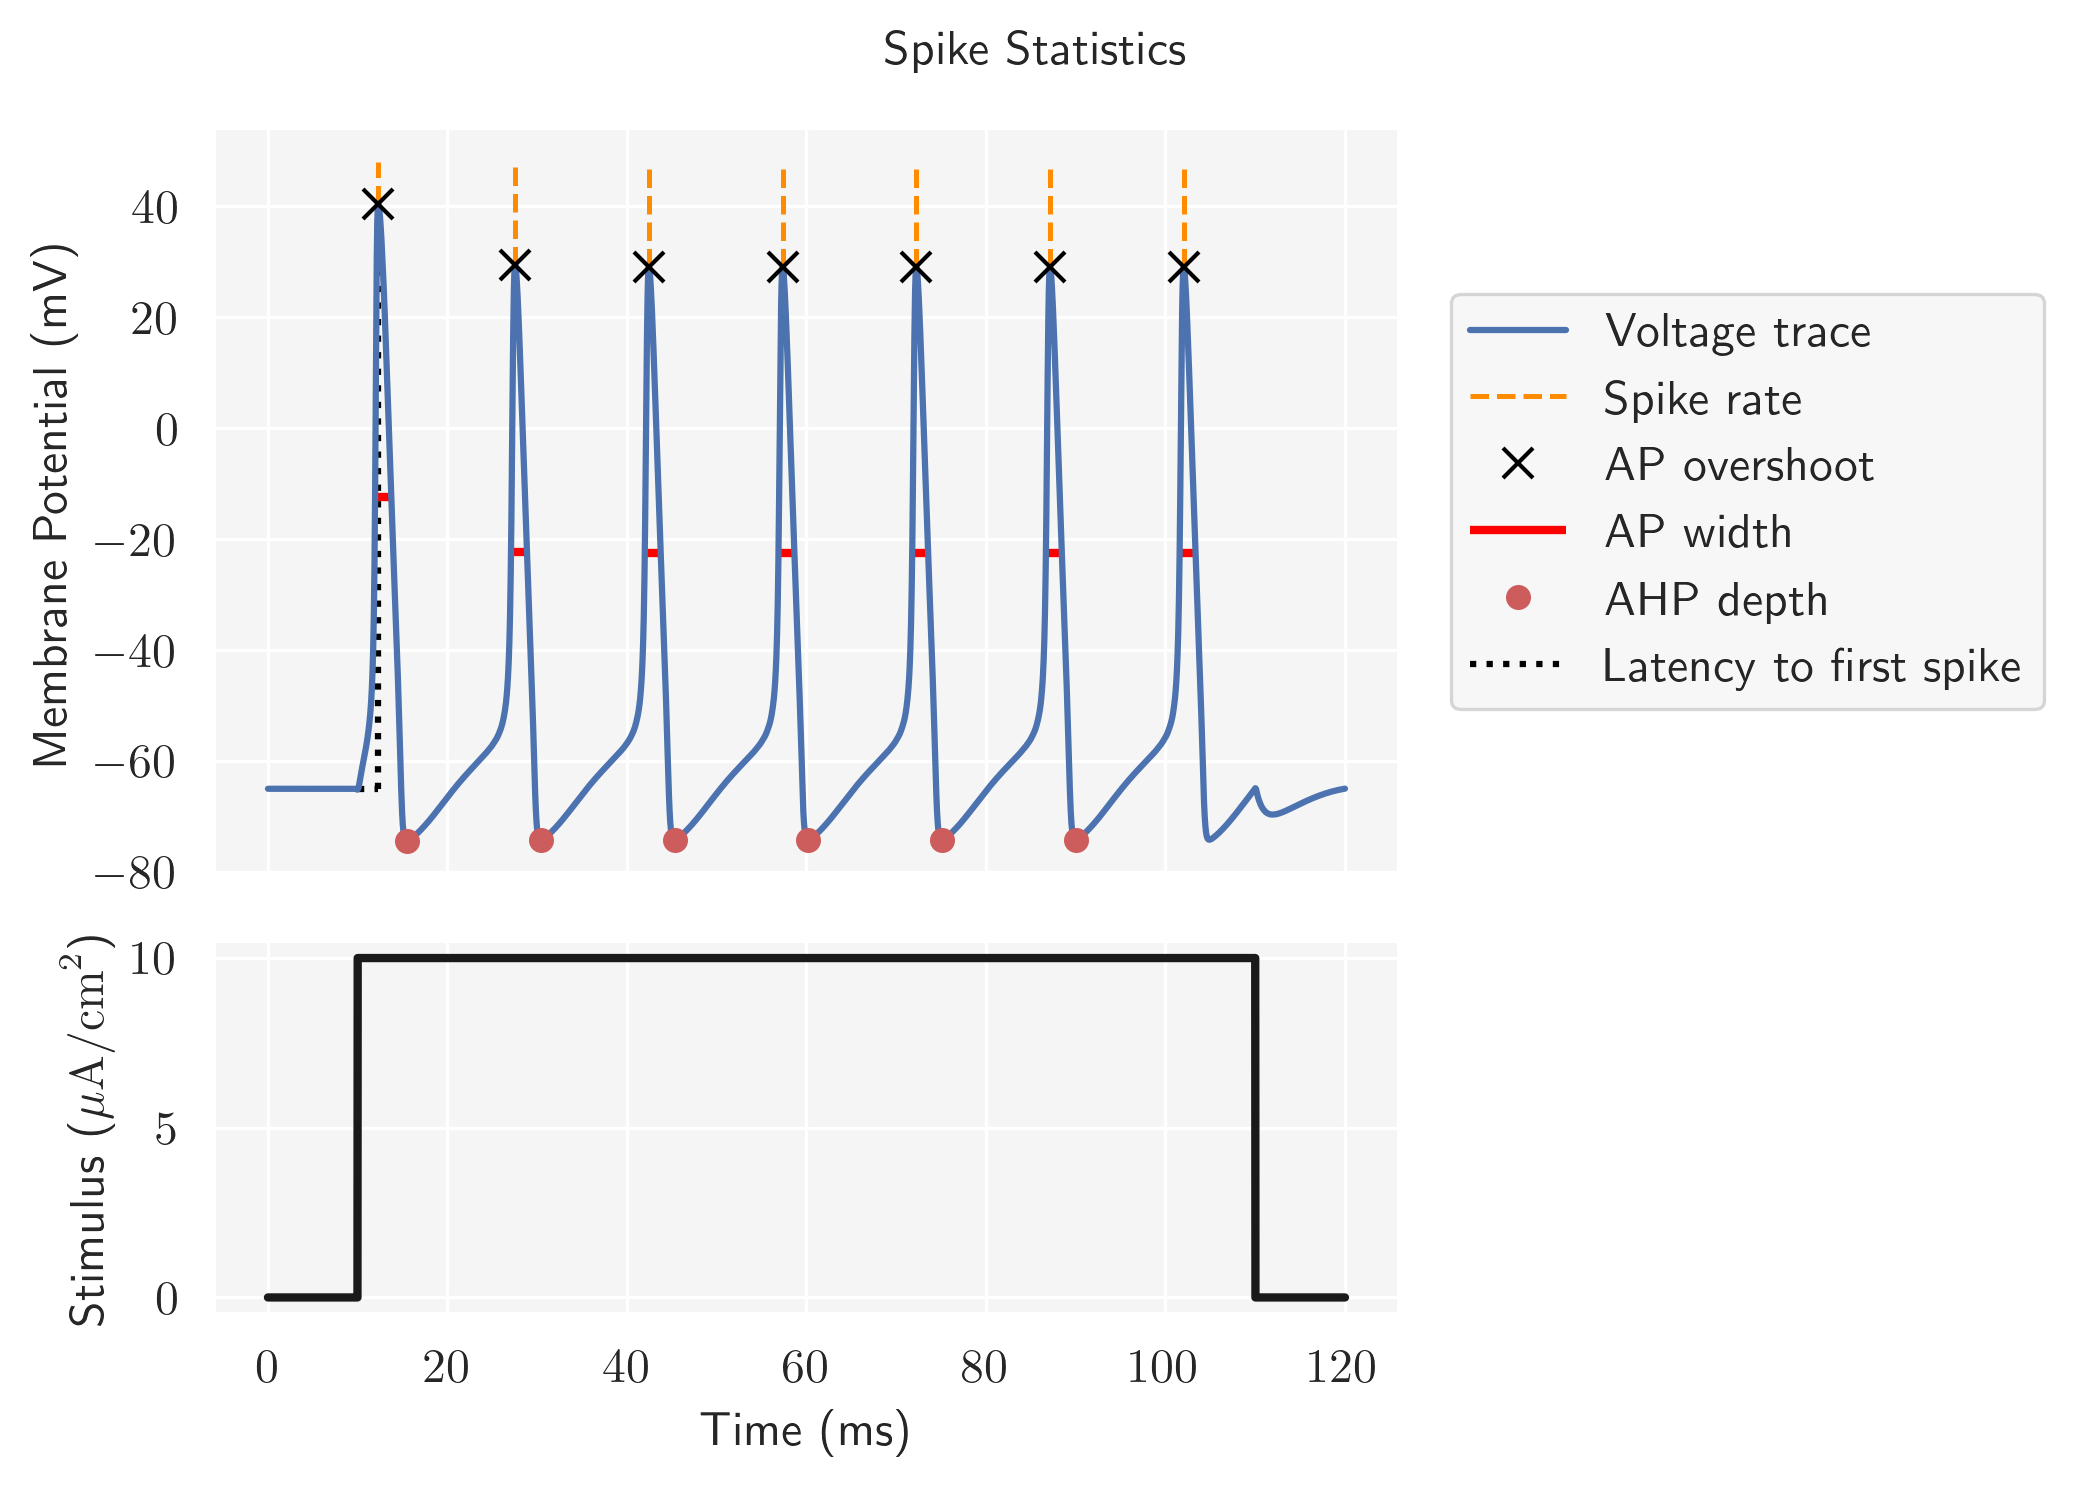

In [41]:
# Figure
fig = plt.figure(figsize=figsize, tight_layout=True, dpi=dpi)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 2])
ax0 = plt.subplot(gs[0])

# voltage trace
ax0.plot(t, V, lw=1.5, label='Voltage trace')

# spike rate; mark spike locations
for i in range(n_spikes):
    if i == 0:
        ax0.vlines(t[spike_idxs[i]], V[spike_idxs[i]], 48, color='darkorange', ls='--', label='Spike rate')
    else:
        ax0.vlines(t[spike_idxs[i]], V[spike_idxs[i]], 48, color='darkorange', ls='--')

# AP overshoot
ax0.plot(t[spike_idxs], V[spike_idxs], "x", ms=7, color='black', label='AP overshoot')

# AP widths
ax0.hlines(*width_lines, color="red", lw=2, label='AP width')

 # AHP depths
ax0.plot(t[ahp_depth_idxs], V[ahp_depth_idxs], 'o', ms=5, color='indianred', label='AHP depth')

# latency to first spike
V_rest = -65.0
ax0.hlines(V_rest, t_stim_on, t[spike_idxs[0]], color='black', lw=1.5, ls=":")
ax0.vlines(t[spike_idxs[0]], V_rest, spike_heights[0], color='black', lw=1.5, ls=":",
           label="Latency to first spike")


# Rest
ax0.set_ylabel('Membrane Potential (mV)')
ax0.axes.xaxis.set_ticklabels([])

handles, labels = ax0.get_legend_handles_labels()
order = [0, 3, 1, 4, 2, 5]
ax0.legend([handles[idx] for idx in order], [labels[idx] for idx in order], 
           #handles, labels,
           loc='center left', bbox_to_anchor=(1.04, 0.5), 
           fancybox=True, borderaxespad=0.1, ncol=1, frameon=True)

ax1 = plt.subplot(gs[1])

stim_array = np.array([stimulus(ti) for ti in t])
ax1.plot(t, stim_array, 'k', lw=2)
ax1.set(xlabel='Time (ms)', ylabel=r'Stimulus ($\mu \mathrm{A/cm}^2$)')

fig.suptitle("Spike Statistics")

fig.savefig('sumstats5.pdf', format='pdf', dpi=300, bbox_inches='tight')

### Accommodation index

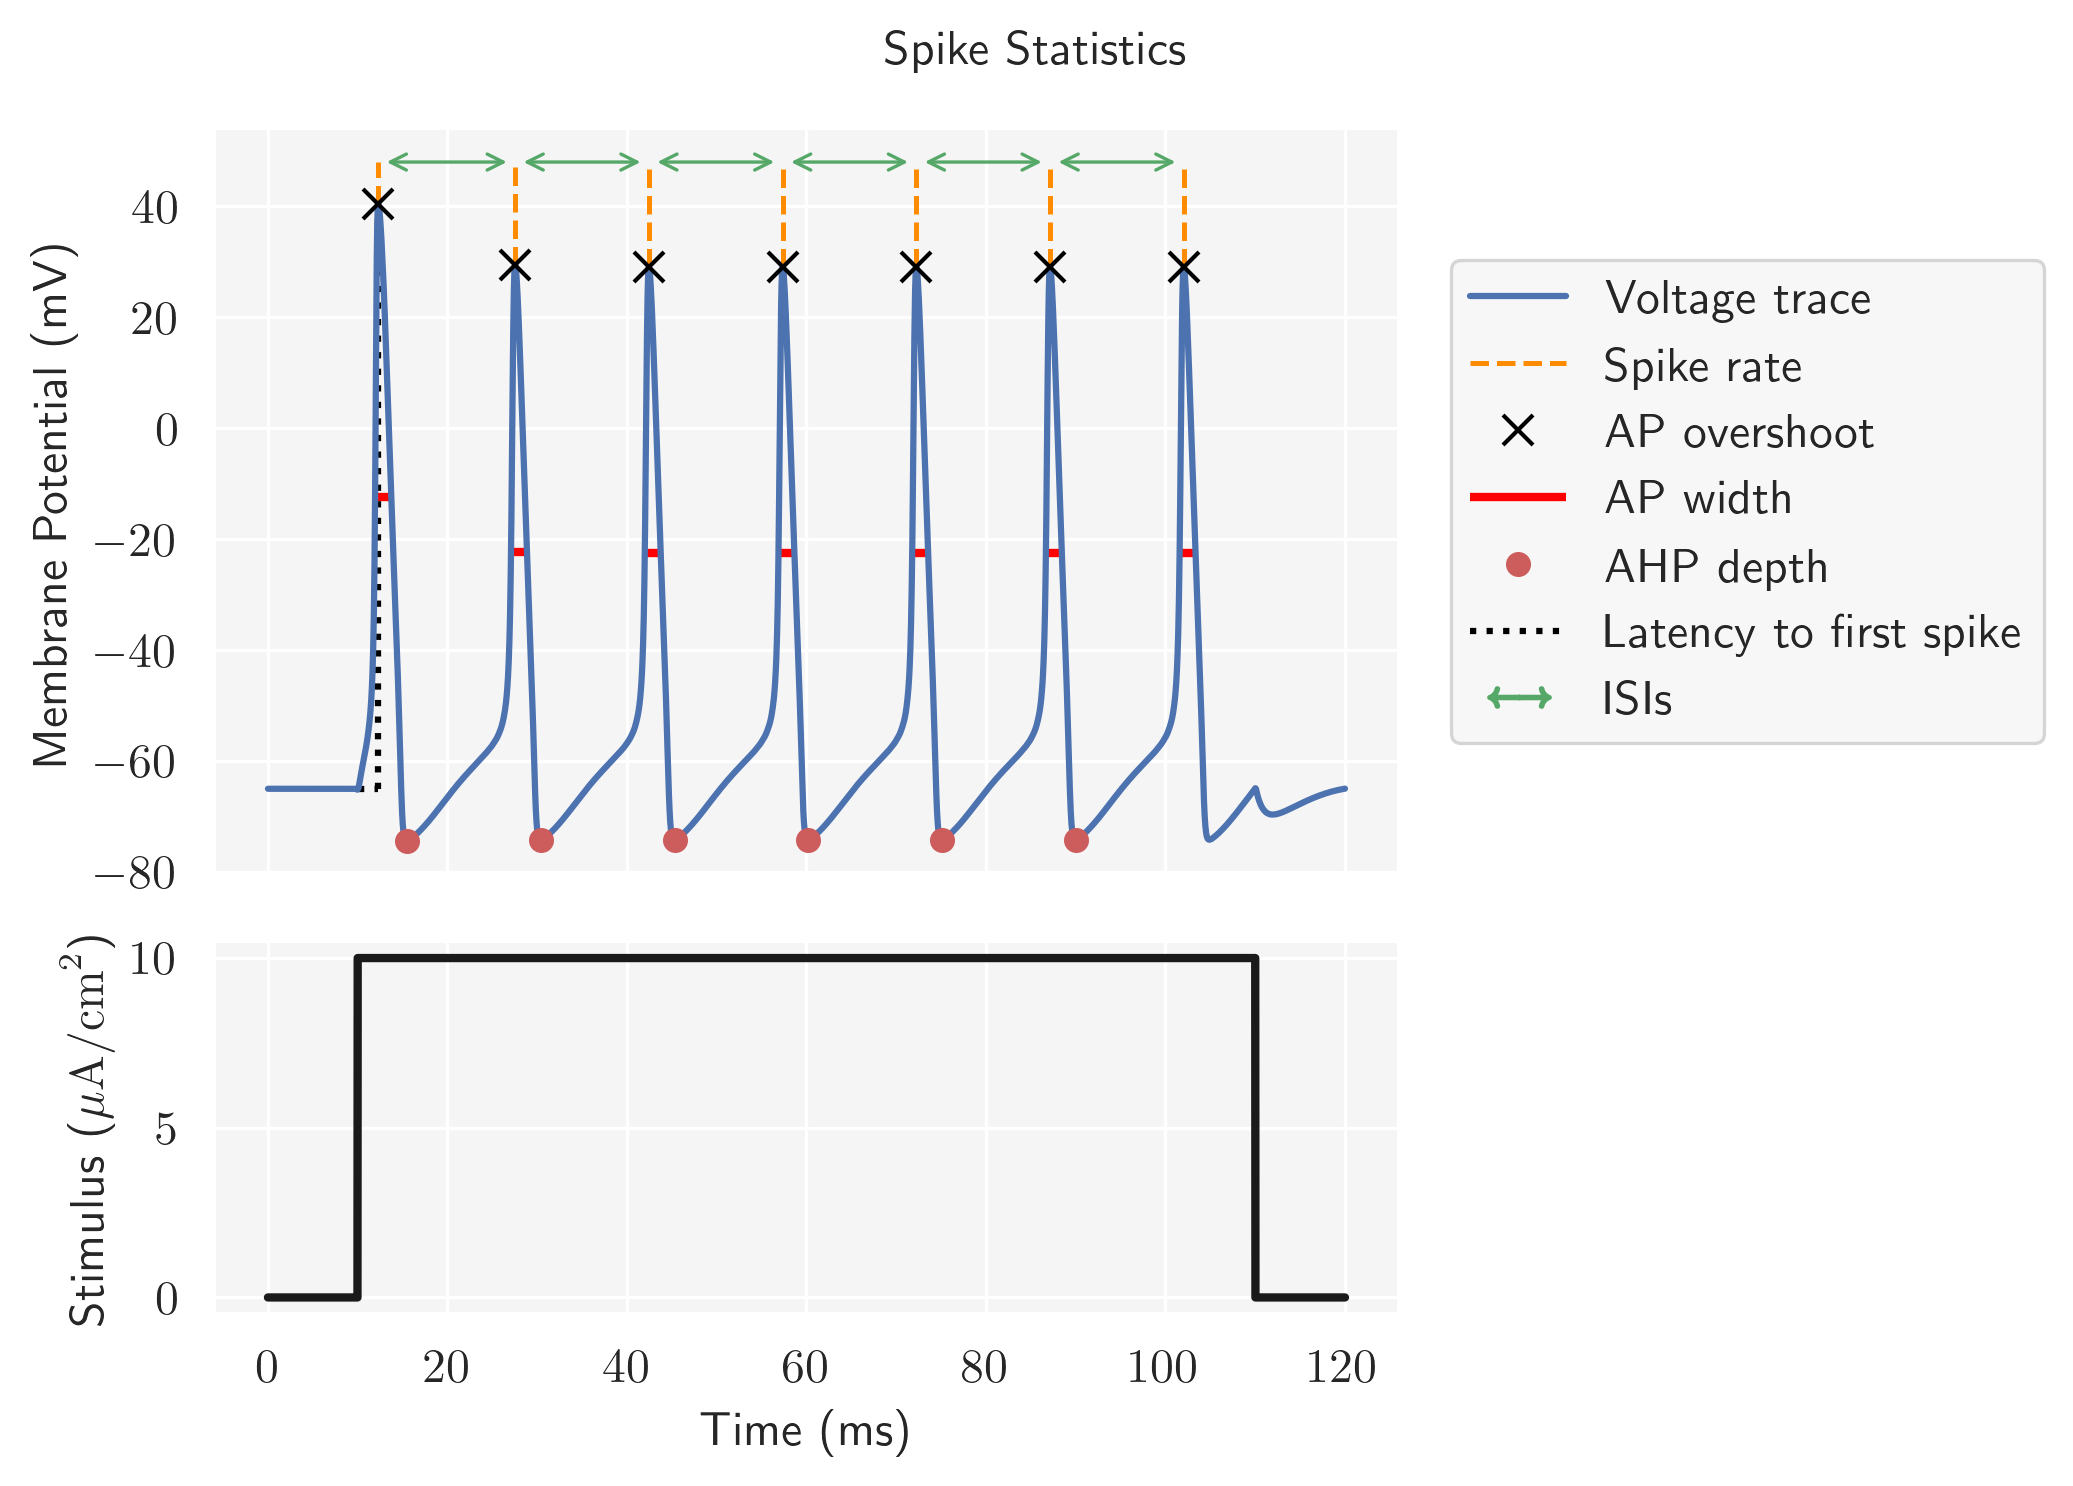

In [43]:
# Figure
fig = plt.figure(figsize=figsize, tight_layout=True, dpi=dpi)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 2])
ax0 = plt.subplot(gs[0])

# voltage trace
ax0.plot(t, V, lw=1.5, label='Voltage trace')

# spike rate; mark spike locations
for i in range(n_spikes):
    if i == 0:
        ax0.vlines(t[spike_idxs[i]], V[spike_idxs[i]], 48, color='darkorange', ls='--', label='Spike rate')
    else:
        ax0.vlines(t[spike_idxs[i]], V[spike_idxs[i]], 48, color='darkorange', ls='--')

# AP overshoot
ax0.plot(t[spike_idxs], V[spike_idxs], "x", ms=7, color='black', label='AP overshoot')

# AP widths
ax0.hlines(*width_lines, color="red", lw=2, label='AP width')

 # AHP depths
ax0.plot(t[ahp_depth_idxs], V[ahp_depth_idxs], 'o', ms=5, color='indianred', label='AHP depth')

# latency to first spike
V_rest = -65.0
ax0.hlines(V_rest, t_stim_on, t[spike_idxs[0]], color='black', lw=1.5, ls=":")
ax0.vlines(t[spike_idxs[0]], V_rest, spike_heights[0], color='black', lw=1.5, ls=":",
           label="Latency to first spike")

# the marked ISIs are used to compute the accommodation index
# ISI arrow legend
ax0.plot([],
         [],
         color='g',
         marker=r'$\longleftrightarrow$',
         linestyle='None',
         markersize=15,
         label='ISIs'
         )
for i in range(n_spikes - 1):
    ax0.annotate('',
                 xy=(t[spike_idxs[i]], 48),
                 xycoords='data',
                 xytext=(t[spike_idxs[i + 1]], 48),
                 textcoords='data',
                 arrowprops={'arrowstyle': '<->', 'color': 'g'}
                 )

# Rest
ax0.set_ylabel('Membrane Potential (mV)')
ax0.axes.xaxis.set_ticklabels([])

handles, labels = ax0.get_legend_handles_labels()
order = [0, 4, 1, 5, 2, 6, 3]
ax0.legend([handles[idx] for idx in order], [labels[idx] for idx in order], 
           #handles, labels,
           loc='center left', bbox_to_anchor=(1.04, 0.5), 
           fancybox=True, borderaxespad=0.1, ncol=1, frameon=True)

ax1 = plt.subplot(gs[1])

stim_array = np.array([stimulus(ti) for ti in t])
ax1.plot(t, stim_array, 'k', lw=2)
ax1.set(xlabel='Time (ms)', ylabel=r'Stimulus ($\mu \mathrm{A/cm}^2$)')

fig.suptitle("Spike Statistics")

fig.savefig('sumstats6.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [ ]:
def plot_spike_statistics(
        self,
        t_stim_on,
        t_stim_off,
        threshold=0,
        figsize=(6, 4),
        dpi=150,
        savefig=None
    ):
        V = self.V
        t = self.t
        sps = SpikeStats(t_stim_on, t_stim_off, threshold, rfp=3.)
        # plot voltage trace with features
        spikes = sps.find_spikes(V, t)
        n_spikes = spikes["n_spikes"]

        if n_spikes < 3:
            msg = ("At least 3 spikes are needed in voltage trace in order "
                   "to plot spike statistics")
            raise RuntimeError(msg)

        spike_idxs = spikes["spike_idxs"]
        spike_heights = spikes["spike_heights"]
        width_lines = sps.width_lines(V, t)
        ahp_depth_idxs = sps.AHP_depth_positions(V, t)

        fig = plt.figure(figsize=figsize, tight_layout=True, dpi=dpi)
        gs = gridspec.GridSpec(2, 1, height_ratios=[4, 2])
        ax0 = plt.subplot(gs[0])

        # voltage trace
        ax0.plot(t,
                 V,
                 lw=1.5,
                 label='Voltage trace'
                 )

        # AP overshoot
        ax0.plot(t[spike_idxs],
                 V[spike_idxs],
                 "x",
                 ms=7,
                 color='black',
                 label='AP overshoot'
                 )

        # AP widths
        ax0.hlines(*width_lines,
                   color="red",
                   lw=2,
                   label='AP width'
                   )

        # AHP depths
        ax0.plot(t[ahp_depth_idxs],
                 V[ahp_depth_idxs],
                 'o',
                 ms=5,
                 color='indianred',
                 label='AHP depth'
                 )

        # latency to first spike
        ax0.hlines(self.V_rest,
                   t_stim_on,
                   t[spike_idxs[0]],
                   color='black',
                   lw=1.5,
                   ls=":"
                   )
        ax0.vlines(t[spike_idxs[0]],
                   self.V_rest,
                   spike_heights[0],
                   color='black',
                   lw=1.5,
                   ls=":",
                   label="Latency to first spike"
                   )
        
        # spike rate; mark spike locations
        for i in range(n_spikes):
            if i == 0:
                ax0.vlines(t[spike_idxs[i]],
                           V[spike_idxs[i]],
                           48,
                           color='darkorange',
                           ls='--',
                           label='Spike rate'
                           )
            else:
                ax0.vlines(t[spike_idxs[i]],
                           V[spike_idxs[i]],
                           48,
                           color='darkorange',
                           ls='--'
                           )
        # the marked ISIs are used to compute the accommodation index
        # ISI arrow legend
        ax0.plot([],
                 [],
                 color='g',
                 marker=r'$\longleftrightarrow$',
                 linestyle='None',
                 markersize=15,
                 label='ISIs'
                 )
        for i in range(n_spikes - 1):
            ax0.annotate('',
                         xy=(t[spike_idxs[i]], 48),
                         xycoords='data',
                         xytext=(t[spike_idxs[i + 1]], 48),
                         textcoords='data',
                         arrowprops={'arrowstyle': '<->', 'color': 'g'}
                         )